# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.   
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255      
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color) 
    #returning the image only where mask pixels are nonzero
    return cv2.bitwise_and(img, mask)
    

def draw_lines(img, lines,bottom_left_y, top_left_y, bottom_right_y, top_right_y, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
#     if lines is not None:
#         for line in lines: 
#             for x1, y1, x2, y2 in line: 
#                 cv2.line(img, (x1,y1), (x2,y2), color, thickness)
    

    
    #save those line segments whose slope values are within the retained slope range 
    X1=np.array([])
    Y1=np.array([])
    X2=np.array([])
    Y2=np.array([])
    if lines is not None: 
        for line in lines:
            for x1,y1,x2,y2 in line:
                m = ((y2-y1)/(x2-x1))
                if m < -0.3:  #exclude near-flat lines
                    X1 = np.append(X1, [x1,x2])
                    Y1 = np.append(Y1, [y1,y2])
                if m > 0.3:
                    X2 = np.append(X2, [x1,x2])
                    Y2 = np.append(Y2, [y1,y2])      
    
    def find_boundary_points_and_draw_line(img, m, b, bottom_y, top_y, color, thickness):
            bottom_x = np.int32((bottom_y-b)/m)
            top_x = np.int32((top_y-b)/m)
            cv2.line(img, (bottom_x, bottom_y), (top_x, top_y), color, thickness) 
            
    if X1.size!=0:   #check if X1 is empty
        #polynomial fit for data_set1 and data_set2 to find coefficients in equation y=mx+b
        z1 = np.polyfit(X1,Y1,1)
        find_boundary_points_and_draw_line(img, z1[0], z1[1], bottom_left_y, top_left_y, color, thickness)
#     else:
#         print('X1 is empty')
        
    if X2.size!=0:  #check if X2 is empty
        z2 = np.polyfit(X2,Y2,1)
        #find boundary points and draw lines 
        find_boundary_points_and_draw_line(img, z2[0], z2[1], bottom_right_y, top_right_y,color, thickness)
#     else:
#         print('X2 is empty')
                

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, bottom_left_y, top_left_y, bottom_right_y, top_right_y):
    """
    `img` should be the output of a Canny transform.
    
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines, bottom_left_y, top_left_y, bottom_right_y, top_right_y)
    return line_img


# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

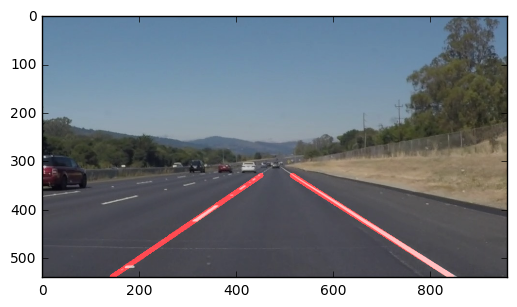

In [4]:
# #reading in an image
# image = mpimg.imread('test_images/solidWhiteRight.jpg')
# #printing out some stats and plotting
# print('This image is:', type(image), 'with dimesions:', image.shape)
# #plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

def display_image(img):
    plt.figure()
    plt.imshow(img, cmap='gray')

def lane_detection(image):
    #define kernel size for Gaussian smoothing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel_size = 5
    blur_image = gaussian_blur(image, kernel_size)

    #define region of interest (grayscale), set by four vertices(counter clockwise)
    y,x = np.shape(gray)
    bottom_left = [0,y-1]
    bottom_right = [x-1, y-1]
    top_left = [x//2-20, y//2+60]
    top_right = [x//2+20, y//2+60]
    vertices = np.array([[bottom_left, bottom_right, top_right, top_left]],dtype=np.int32)

    
    #produce color mask to retain yellow and white colors on the original image
    #example http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html
    hsv=cv2.cvtColor(blur_image, cv2.COLOR_BGR2HSV)
    # Threshold the image to get only yellow and white colors
    yellow_mask = cv2.inRange(hsv, np.uint8([80,100,100]), np.uint8([110,255,255]))
    #http://stackoverflow.com/questions/25398188/black-color-object-detection-hsv-range-in-opencv 
    #white_mask = cv2.inRange(hsv, np.uint8([0,80,200]), np.uint8([180,255,255]))
    white_mask = cv2.inRange(blur_image, np.uint8([190,190,190]), np.uint8([255,255,255]))
    # Bitwise-OR yellow_mask and white_mask
    color_mask=cv2.bitwise_or(yellow_mask, white_mask)
    
    high_thresh = 150      
    low_thresh = 100
    color_mask_edges = canny(color_mask, low_thresh, high_thresh)
    ROI_color_mask = region_of_interest(color_mask_edges, vertices)
    

    #run Hough transform on ROI_edges
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 20
    max_line_gap = 100
    #create a "color" binary image to combine with original image
    #line_image_copy = np.copy(line_image)* 0
    #color_hough_line = np.dstack((line_image, line_image_copy, line_image_copy))

    line_image = hough_lines(ROI_color_mask, rho, theta, threshold, min_line_length, max_line_gap, 
                             bottom_left[1], top_left[1], bottom_right[1], top_right[1])
    
    
    #create a "color" binary image to combine with original image
    line_image_copy = np.copy(line_image)* 0
    color_hough_line = np.dstack((line_image, line_image_copy, line_image_copy))

    #display hough lines on original image
    return weighted_img(color_hough_line, image, α=0.8, β=1., λ=0.) 
    
    
image_str = 'test_images/solidWhiteRight.jpg'
image = mpimg.imread(image_str)

if image is not None:
    lane_image = lane_detection(image)
    display_image(lane_image)

    #change [r,g,b] to [b,g,r] cv2.imwrite()
    def rgb_to_bgr(image):
        r,g,b = cv2.split(image)
        image_bgr = cv2.merge([b,g,r])
        return image_bgr

    lane_bgr = rgb_to_bgr(lane_image)
    cv2.imwrite('new.jpg', lane_bgr)


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
image_list = os.listdir("test_images/")

for image_str in image_list:
    image = mpimg.imread('test_images/'+image_str)
    lane_image = lane_detection(image)
    lane_bgr = rgb_to_bgr(lane_image)
    cv2.imwrite('test_images/s1_'+image_str, lane_bgr)






run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    return lane_detection(image)

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:11<00:00, 19.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 12.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:36<00:00, 16.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 38.8 s


In [54]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

#### Non Challenge Part
My first complete version was finished within a couple of hours. Version one is straightforward and follows the sequence below,
1. read image 
2. convert to grayscale
3. smooth the grayscale image with a Gaussian filter
4. detect canny edges
5. retain only the canny edges in a defined polygon region
        5.1 define a polygon region 
        5.2 bitwise_and the original canny edges with this polygon region 
6. run Hough transform to find line segments (A line segment can be mathematically represented by y=mx+b)
        6.1 create two histograms with the slope m data, one for positive range and the other for negative range. Both 
        ranges exclude near-horizontal line 
        6.2 choose the most prominent peak for each histogram
        6.3 keep those line segments whose slopes m are within the range of the most prominent peaks
7. run linear line fitting to compute slope m and intercept b
        7.1 compute the start and end points of each lane, given that both points sit at the boundary of the defined 
        polygon
8. draw lane lines on the original color image

After running on the example images, I realised those line segments parallel to and offset from the lane line did affect the results. These line segments usually are grayish color, neither white nor yellow. 

Then in version two, a color mask was applied before running Hough transform. The color mask retains yellowish and white color of the orginal image and then bitwise_and with the canny edges in the polygon region. Version two works perfect for solidWhiteRight.mp4 and solidYellowLeft.mp4. The algorithm is robust to contrast and illuminance. 

#### Challenge Part
However, version two is not robust to the color transition of the high way, from dark gray to light gray and vice versa, in challenge.mp4. I tried tweaking the color mask to filter away the grayish color, but the algorithm still failed to differentiate between color transition of the high way and lane lines. I also tried tweaking the slope selection criterion to choose more slanted lines since the false positive lines are nearly flat. However for some video frames, this did not work because it detected no lines at all.

I believe the false positives could be avoided by tweaking variables but it is really time consuming and more like guessing. After spending two days on tweaking, the result turned out no improvement. I decided to submit the current algorithm first and move on to the machine learning lesson. Meanwhile, I try to get some hint from the forum and continue working on the challenge video.  







## Final Version 
This version 3 works perfect for the challenge video. After my first submisison, I spent another day to redo the unit test. In the end, I found out there was something incorrect in the algorithm pipeline. 
I deleted bitwise_and between the color mask and canny edges since this step incorrectly washed out non-overlapping but true lane lines. I deleted creating histogram method as it did not help much,  which I previously thought as an automatic way to compute the most two prominent slopes for the left lane and right lane. 

Other than that, I defined yellow mask in hsv colorspace but white mask in rgb colorspace. It turns out the white mask defined in rgb colorspace performs much better result than that defined in hsv colorspace. 

Further, by tuning the Hough line parameters threshold, min_line_length, max_line_gap as suggested by the reviewer, eventually my algorithm can correctly detect lane lines in the challenge video. 

To make the pipeline more complete, I considered some fatal scenario such as no Hough line detected at all. In this case, we need conditional statement, only when Hough lines detected, then it proceeds to line fitting, otherwise it skips the remaining steps. However, if we process video rather than a single image, we can actually retain the lane information of previous frame to draw detected lane lines on the present frame.   


###### The new algorithm pipeline works as follows.
1. read image 
2. convert to grayscale
3. smooth the original image with a Gaussian filter (kernel size = 5)
4. run color mask on the smoothed color image, and the result is a binary image 
        4.1 define yellow mask, white mask and bitwise_or to combine as color mask.  
5. detect canny edges on the color mask image
5. retain only the canny edges in a defined polygon region
        5.1 define a polygon region 
        5.2 bitwise_and the original canny edges with this polygon region         
6. run Hough transform to find line segments (A line segment can be mathematically represented by y=mx+b)
        6.1 if no line segments are detected, then the algorithm just skip the the remaining steps, no line fitting or 
        drawing lines will be executed. 
7. run linear line fitting to compute slope m and intercept b
        7.1 compute the start and end points of each lane, given that both points sit at the boundary of the 
        defined polygon.
8. draw lane lines on the original color image



#### Lesson Learned
Be patient and must do unit test!







## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [10]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████| 251/251 [00:31<00:00,  6.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 35.2 s


In [126]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))